In [32]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import FinanceDataReader as fdr
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Conv1D, Lambda
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# 수집한 데이터

In [70]:
df = pd.read_excel('./data/samsung10.xlsx')
data = df.copy()

In [34]:
data = data.drop(index = [2451,2452,2453,2454,2455,2456,2457,2458,2459,2460], axis=0)

In [35]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2451 entries, 0 to 2450
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   DATE           2451 non-null   datetime64[ns]
 1   거래량            2451 non-null   int64         
 2   PER            2451 non-null   float64       
 3   PBR            2451 non-null   float64       
 4   기관 합계          2451 non-null   int64         
 5   기타법인           2451 non-null   int64         
 6   개인             2451 non-null   int64         
 7   외국인 합계         2451 non-null   int64         
 8   ATR            2451 non-null   int64         
 9   NASDAQ         2451 non-null   object        
 10  S&P            2451 non-null   object        
 11  CBOE           2451 non-null   float64       
 12  Exchange rate  2451 non-null   object        
 13  futures2y      2451 non-null   float64       
 14  futures10y     2451 non-null   float64       
 15  y              2451 n

In [36]:
# 실수형으로 변환

data['CBOE'] = data['CBOE'].astype('float')
data['futures2y'] = data['futures2y'].astype('float')
data['futures10y'] = data['futures10y'].astype('float')

In [37]:
# 실수형으로 변환(값에 ','가 포함된 경우)

data['NASDAQ'] = data['NASDAQ'].str.replace(',', '').astype(float)
data['S&P'] = data['S&P'].str.replace(',', '').astype(float)
data['Exchange rate'] = data['Exchange rate'].str.replace(',', '').astype(float)

In [38]:
scaler = MinMaxScaler()

In [39]:
scale_cols = ['거래량', 'PER', 'PBR', '기관 합계', '기타법인', '개인', '외국인 합계', 'ATR', 'NASDAQ', 'S&P', 'CBOE', 'Exchange rate', 'futures2y', 'futures10y', 'y']

In [40]:
scaled = scaler.fit_transform(data[scale_cols])
scaled

array([[0.37435295, 0.07735281, 0.07361963, ..., 0.95700935, 0.57105031,
        0.01318565],
       [0.11073659, 0.07692308, 0.06748466, ..., 0.95140187, 0.60150044,
        0.01397679],
       [0.12154377, 0.06145251, 0.03067485, ..., 0.95140187, 0.60150044,
        0.01450422],
       ...,
       [0.44899842, 0.6265578 , 0.50920245, ..., 0.94766355, 0.69638129,
        0.77979958],
       [0.6662848 , 0.59733563, 0.47239264, ..., 0.95327103, 0.7184466 ,
        0.78375527],
       [0.31774018, 0.59518694, 0.46625767, ..., 0.95327103, 0.7325684 ,
        0.81144515]])

In [41]:
df = pd.DataFrame(scaled, columns=scale_cols)

In [42]:
x_train, x_test, y_train, y_test = train_test_split(df.drop('y', 1), df['y'], test_size=0.2, random_state=0, shuffle=False)

In [43]:
x_train.shape, y_train.shape, x_test.shape, y_test.shape

((1960, 14), (1960,), (491, 14), (491,))

In [44]:
def windowed_dataset(series, window_size, batch_size, shuffle):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    if shuffle:
        ds = ds.shuffle(1000)
    ds = ds.map(lambda w: (w[:-1], w[-1]))
    return ds.batch(batch_size).prefetch(1)

In [45]:
WINDOW_SIZE=120
BATCH_SIZE=32

In [46]:
train_data = windowed_dataset(y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(y_test, WINDOW_SIZE, BATCH_SIZE, False)

In [47]:
for data in train_data.take(1):
    print(f'데이터셋(X) 구성(batch_size, window_size, feature갯수): {data[0].shape}')
    print(f'데이터셋(Y) 구성(batch_size, window_size, feature갯수): {data[1].shape}')

데이터셋(X) 구성(batch_size, window_size, feature갯수): (32, 120, 1)
데이터셋(Y) 구성(batch_size, window_size, feature갯수): (32, 1)


In [48]:
model = Sequential([
    # 1차원 feature map 생성
    Conv1D(filters=32, kernel_size=5,
           padding="causal",
           activation="relu",
           input_shape=[WINDOW_SIZE, 1]),
    # LSTM
    LSTM(16, activation='tanh'),
    Dense(16, activation="relu"),
    Dense(1),
])

In [49]:
loss = Huber()
optimizer = Adam(0.0005)
model.compile(loss=Huber(), optimizer=optimizer, metrics=['mse'])

In [52]:
earlystopping = EarlyStopping(monitor='val_loss', patience=100, mode='min')
filename = os.path.join('tmp', 'ckeckpointer.ckpt')
checkpoint = ModelCheckpoint(filename, 
                             save_weights_only=True, 
                             save_best_only=True, 
                             monitor='val_loss', 
                             verbose=1)

In [53]:
history = model.fit(train_data, 
                    validation_data=(test_data), 
                    epochs=1000, 
                    callbacks=[checkpoint, earlystopping])

Epoch 1/200
58/58 [==============================] - 5s 84ms/step - loss: 1.8846e-04 - mse: 3.7692e-04 - val_loss: 0.0016 - val_mse: 0.0033

Epoch 00001: val_loss improved from inf to 0.00164, saving model to tmp\ckeckpointer.ckpt
Epoch 2/200
58/58 [==============================] - 3s 52ms/step - loss: 1.2026e-04 - mse: 2.4051e-04 - val_loss: 0.0016 - val_mse: 0.0032

Epoch 00002: val_loss improved from 0.00164 to 0.00162, saving model to tmp\ckeckpointer.ckpt
Epoch 3/200
58/58 [==============================] - 3s 47ms/step - loss: 1.1838e-04 - mse: 2.3676e-04 - val_loss: 0.0020 - val_mse: 0.0040

Epoch 00003: val_loss did not improve from 0.00162
Epoch 4/200
58/58 [==============================] - 3s 54ms/step - loss: 1.1568e-04 - mse: 2.3136e-04 - val_loss: 0.0015 - val_mse: 0.0031

Epoch 00004: val_loss improved from 0.00162 to 0.00154, saving model to tmp\ckeckpointer.ckpt
Epoch 5/200
58/58 [==============================] - 3s 47ms/step - loss: 1.1351e-04 - mse: 2.2703e-04 - va

58/58 [==============================] - 3s 54ms/step - loss: 5.9668e-05 - mse: 1.1934e-04 - val_loss: 7.0485e-04 - val_mse: 0.0014

Epoch 00040: val_loss did not improve from 0.00064
Epoch 41/200
58/58 [==============================] - 3s 52ms/step - loss: 5.8109e-05 - mse: 1.1622e-04 - val_loss: 5.1650e-04 - val_mse: 0.0010

Epoch 00041: val_loss improved from 0.00064 to 0.00052, saving model to tmp\ckeckpointer.ckpt
Epoch 42/200
58/58 [==============================] - 3s 45ms/step - loss: 6.1503e-05 - mse: 1.2301e-04 - val_loss: 4.7344e-04 - val_mse: 9.4688e-04

Epoch 00042: val_loss improved from 0.00052 to 0.00047, saving model to tmp\ckeckpointer.ckpt
Epoch 43/200
58/58 [==============================] - 4s 58ms/step - loss: 5.8375e-05 - mse: 1.1675e-04 - val_loss: 4.4105e-04 - val_mse: 8.8210e-04

Epoch 00043: val_loss improved from 0.00047 to 0.00044, saving model to tmp\ckeckpointer.ckpt
Epoch 44/200
58/58 [==============================] - 5s 76ms/step - loss: 5.7143e-05 - 

In [54]:
model.load_weights(filename)

In [55]:
pred = model.predict(test_data)

In [56]:
pred.shape

(371, 1)

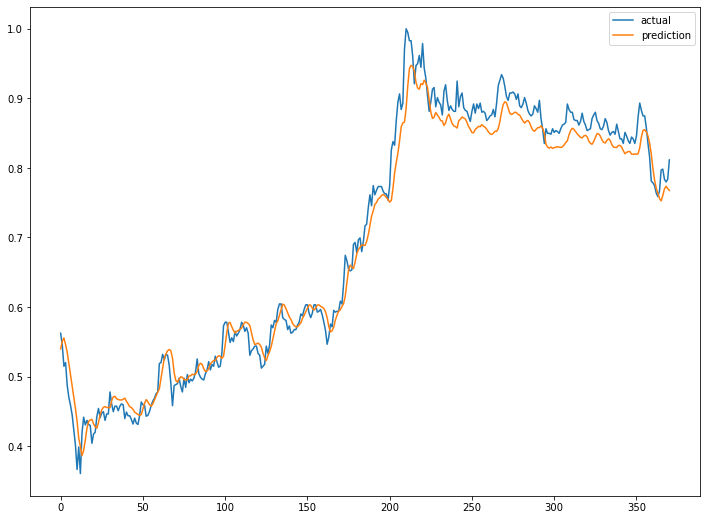

In [57]:
plt.figure(figsize=(12, 9))
plt.plot(np.asarray(y_test)[120:], label='actual')
plt.plot(pred, label='prediction')
plt.legend()
plt.show()

In [58]:
def RMSE(y_test, pred):
    return np.sqrt(mean_squared_error(y_test[120:], pred))

print('RMSE : ', RMSE(y_test, pred)) 

RMSE :  0.026646879327988537


In [59]:
r2_y_predict = r2_score(y_test[120:], pred)

print('R2 : ', r2_y_predict)

R2 :  0.9784257648651188


In [60]:
# val_lose 0.00013
# RMSE : 0.01586393814653742
# R2 : 0.9922155763036076

# 예측

In [72]:
df = df.drop(index = [2451,2452,2453,2454,2455,2456,2457,2458,2459,2460], axis=0)

In [73]:
data_y = np.array(df['y'])
data_y = data_y.reshape(-1,1)

In [74]:
scaler_y = MinMaxScaler()
scaled_y = scaler_y.fit_transform(data_y)

In [75]:
pred_data = windowed_dataset(scaled_y, WINDOW_SIZE, BATCH_SIZE, False)

In [76]:
pred_data

<PrefetchDataset shapes: ((None, None, 1, 1), (None, 1, 1)), types: (tf.float64, tf.float64)>

In [77]:
prediction = model.predict(pred_data)

In [78]:
prediction

array([[0.11969366],
       [0.12229881],
       [0.12512085],
       ...,
       [0.77366364],
       [0.770196  ],
       [0.7675177 ]], dtype=float32)

In [79]:
prediction = scaler_y.inverse_transform(prediction)  # 0~1의 값으로 정규화된 값을 원래의 크기로 되돌린다.  
print("predicted 10 days later final price", prediction[-1])  # 예측한 값을 출력한다. 

predicted 10 days later final price [73368.54]


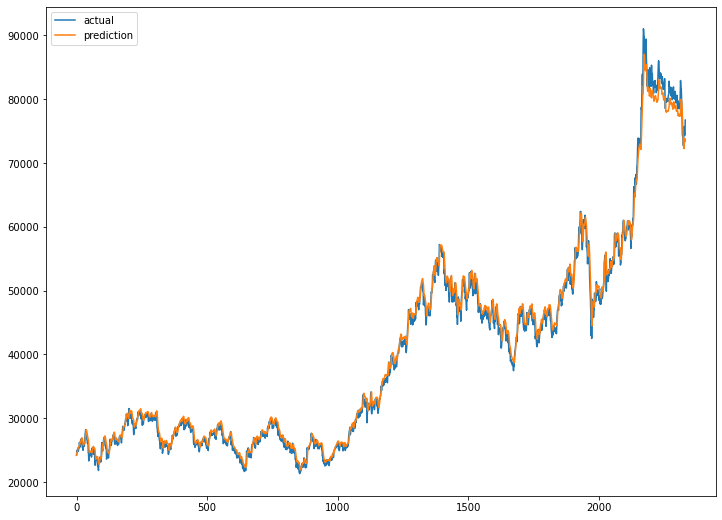

In [80]:
plt.figure(figsize=(12, 9))
plt.plot(data_y[120:], label='actual')
plt.plot(prediction, label='prediction')
plt.legend()
plt.show()